# Sentiment Analysis App for Twitter

## Importing libraries

In [55]:
import os
import sys
import time

import re
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.stem import  WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

## Imporing Data

In [56]:
csv_path = "../Data/training_data.csv"

In [57]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["Sentiment", "Id", "Date", "Flag", "User", "Text"]

In [58]:
data_df = pd.read_csv(csv_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data_df.head()

,Sentiment,Id,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Data
### Changing the sentiment data such that:
 **- 0 : Negative**
 **- 1 : Positive**

In [59]:
columns_req = ["Sentiment", "Text"]
data_df = data_df[columns_req]

In [60]:
data_df["Sentiment"] = data_df["Sentiment"].replace(4,1)

In [61]:
data_df.Sentiment.value_counts()

0    800000
1    800000
Name: Sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

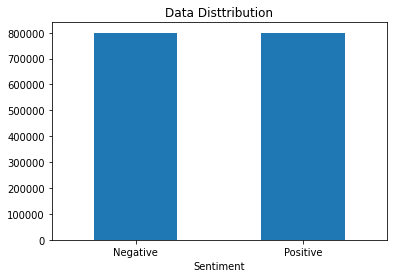

In [62]:
ax = data_df.groupby('Sentiment').count().plot(kind='bar', title='Data Disttribution', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

In [63]:
text , sentiment = list(data_df['Text']), list(data_df['Sentiment'])

## Text Preprocessing
**Text Preprocessing** is important for making data easier for training

**The preprocessing steps include:**
1. **Lower casing:** Each word is converted to lowercase
2. **Replacing URLs:** Links starting with **"http", "https" or "www"** are replaced by **"URL"**
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [64]:
# Defining dictionary containing all emojis with their meaning

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english.
# stopwordlist = set(stopwords.words("english"))

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [65]:
def preprocess(textdata):
    processedText = []

    # Lemmatizer and Stemmer
    wordlemm = WordNetLemmatizer()

    # Defining regex pattern.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern, ' URL', tweet) # Using "URL" in place of URL's

        for emoji in emojis.keys(): # Replacing emojis
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        tweet = re.sub(userPattern, ' USER', tweet) # Replacing @username with USER

        tweet = re.sub(alphaPattern, " ", tweet) # Replacing all non alphabets

        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # Replacing 3 more consecutive letters by 2 letters

        tweetwords = ''

        for word in tweet.split():

            if word not in stopwordlist:
                if len(word)>1:
                    word = wordlemm.lemmatize(word)
                    tweetwords += (word + ' ')

        processedText.append(tweetwords)

    return processedText


In [66]:
t = time.time()
processedtext = preprocess(text)

In [67]:
print(f'Time Taken: {round(time.time()-t)} seconds')

Time Taken: 80 seconds


## Data Analysis

We will use **Word Clouds** for understanding our data

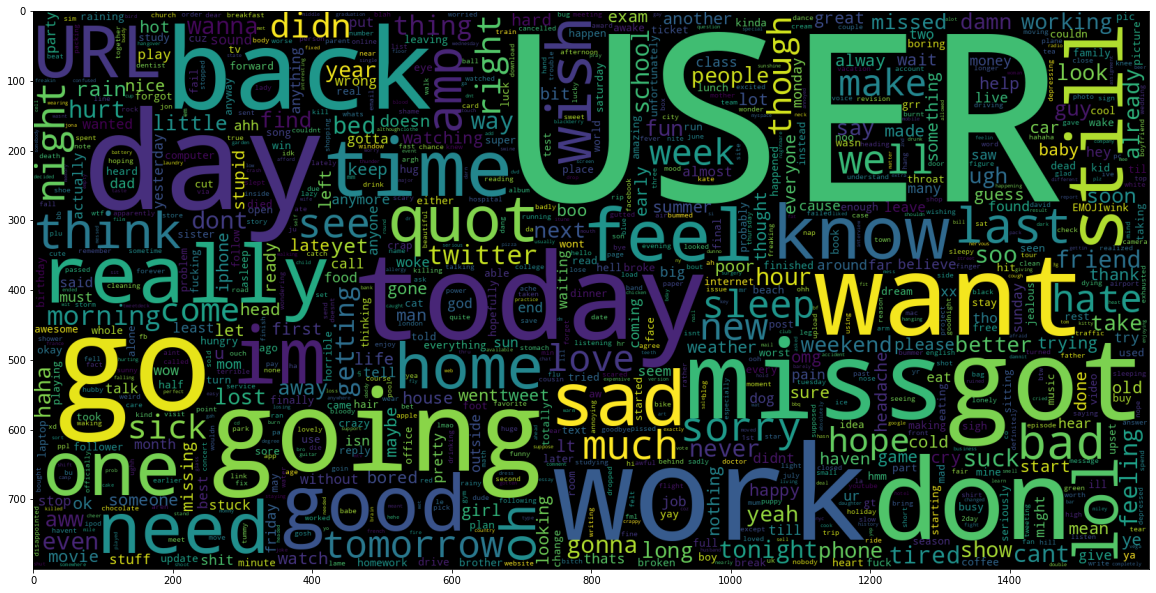

In [68]:
Negative_tweets = processedtext[:800000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000,width=1600, height=800, collocations=False).generate(" ".join(Negative_tweets))
plt.imshow(wc)

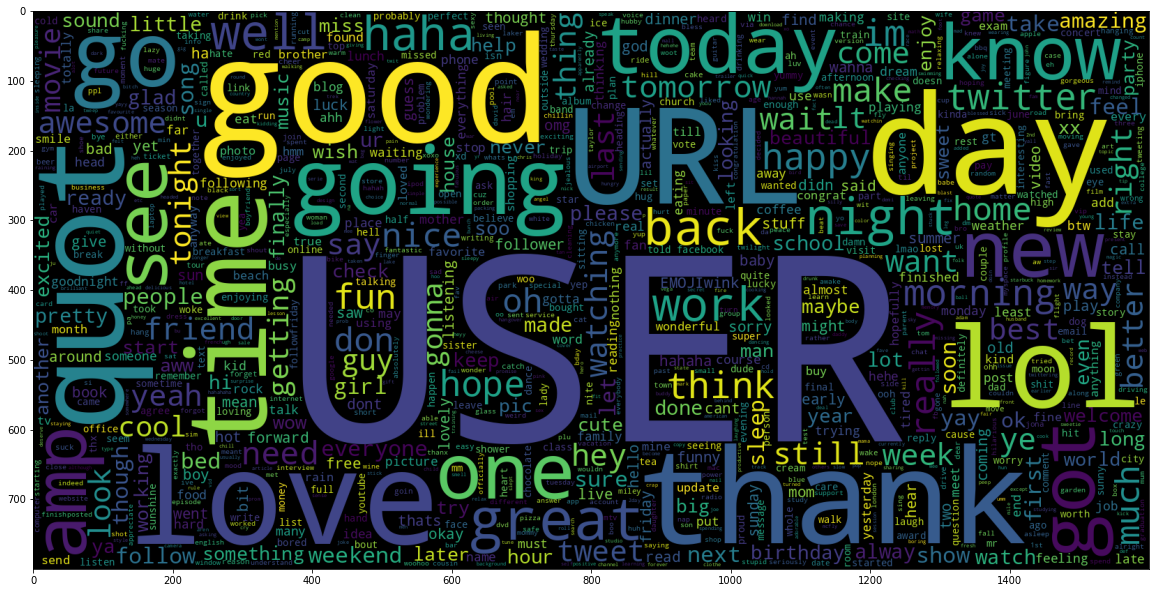

In [69]:
Positive_tweets = processedtext[800000:]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000,width=1600, height=800, collocations=False).generate(" ".join(Positive_tweets))
plt.imshow(wc)

## Splitting the Data

The preprocesses data will be divided into training and testing data.

* **Training data:** Used to train model (90% data).
* **Testing daya:** Used to test model performance (10% data).

In [70]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.1, random_state=0)

In [71]:
len(X_train)

1440000

In [72]:
len(X_test)

160000

## TF - IDF Vectoriser

In [73]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [74]:
print('No of feature words: ', len(vectoriser.get_feature_names_out()))

No of feature words:  500000


In [75]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Training Models

We will train our models on 3 models:
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

**Model evaluation Function**

In [76]:
def model_evaluation(model):
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    confusionmatrx = confusion_matrix(y_test, y_pred)

    categories = ['negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in confusionmatrx.flatten() / np.sum(confusionmatrx)]

    labels = [f'{v1}\n{v2}' for v1,v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(confusionmatrx, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size':14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':14}, pad=20)

### BernoulliNB Model

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     79738
           1       0.79      0.81      0.80     80262

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



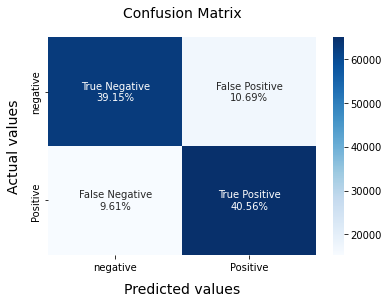

In [77]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_evaluation(BNBmodel)

### LinearSVC Model

In [78]:
# SVCmodel = LinearSVC()
# SVCmodel.fit(X_train, y_train)
# model_evaluation(SVCmodel)

### Logistic Regression Model

In [79]:
# LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
# LRmodel.fit(X_train, y_train)
# model_evaluation(LRmodel)

## Saving the models

In [80]:
file = open('../Data/vectoriser-ngram(1,2).pickle', 'wb')
pickle.dump(vectoriser, file)
file.close()

In [81]:
file = open('../Data/BNBmodel.pickle', 'wb')
pickle.dump(BNBmodel, file)
file.close()